Metadata for x: {'OSR': 8.0, 'fs': 10000.0}
Metadata for y: {'OSR': 8.0, 'fs': 10000.0}
Metadata for y_serial: {'OSR': 8.0, 'fs': 10000.0, 'lut_name': 1.0, 'lut_size': 16.0}
LUT size: 16
LUT name: 1


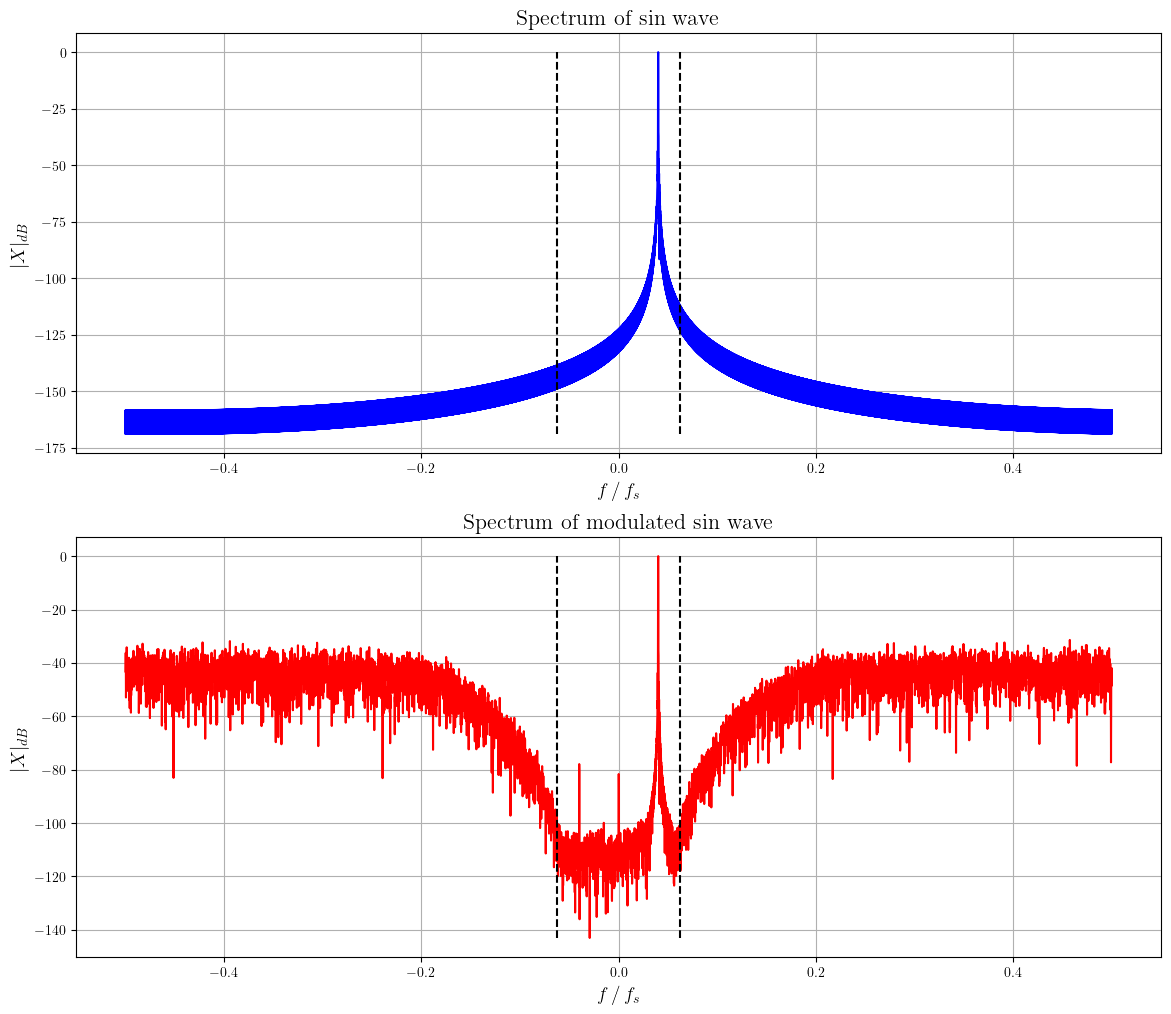

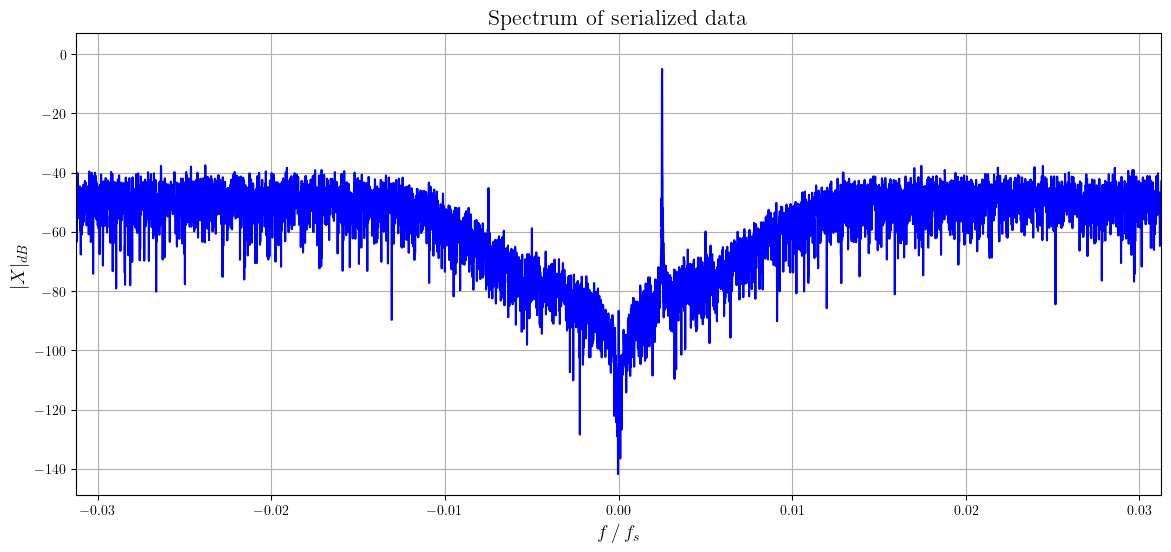

In [1]:
import os
import numpy as np
import scipy.signal as signal
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    data.append(complex(line.strip()))  # Assuming float values in the data
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)


def assign_metadata_to_variables(metadata):
    """
    Assign metadata values to local variables based on keys.
    
    Args:
        metadata (dict): Metadata key-value pairs.
    
    Returns:
        dict: A dictionary containing local variables for each metadata key.
    """
    local_vars = {}
    for key, value in metadata.items():
        local_vars[key] = value  # Store metadata as local variables in a dictionary
    return local_vars

def plotSpectrum(Y, X, OSR, title='Spectrum', xlabel=r'$f \, / \, f_s$', ylabel=r'$|X|_{dB}$', color='blue'):
    plt.plot(Y, X - np.max(X), color=color)
    plt.plot([0.5 / OSR, 0.5 / OSR], [np.min(X - np.max(X)), np.max(X - np.max(X))], '--k', linewidth=1.5)
    plt.plot([-0.5 / OSR, -0.5 / OSR], [np.min(X - np.max(X)), np.max(X - np.max(X))], '--k', linewidth=1.5)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid()


def main():
    # Read data and metadata
    x_meta, x = read_file_with_header('../data/sinData.txt')
    y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')
    y_serial_meta, y_serial = read_file_with_header('../data/sinData_serialData.txt')

    # Assign metadata to local variables
    x_vars = assign_metadata_to_variables(x_meta)
    y_vars = assign_metadata_to_variables(y_meta)
    y_serial_vars = assign_metadata_to_variables(y_serial_meta)

    # Extraction of metadata
    OSR = int(x_vars.get("OSR", 1))  # Use default OSR=1 if not found in metadata
    fs = x_vars.get("fs", None)
    lut_name = int(y_serial_vars.get("lut_name", -1))  # Default to "unknown" if not found
    lut_size = int(y_serial_vars.get("lut_size", 0))  # Add LUT size handling

    print(f"Metadata for x: {x_vars}")
    print(f"Metadata for y: {y_vars}")
    print(f"Metadata for y_serial: {y_serial_vars}")
    print(f"LUT size: {lut_size}")
    print(f"LUT name: {lut_name}")

    # Process and plot data
    w = signal.barthann(len(x), False)
    x_win = x * w
    y_win = y * w

    XdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_win))))
    YdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(y_win))))

    freqs = (np.arange(len(x)) / len(x) - 0.5)

    # Plotting
    plt.figure(figsize=(14, 12))
    # First subplot for XdB
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
    plotSpectrum(Y=freqs, X=XdB, OSR=OSR, title=r'Spectrum of sin wave', xlabel=r'$f \, / \, f_s$', ylabel='$|X|_{dB}$', color='blue')
    # Second subplot for YdB
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
    plotSpectrum(Y=freqs, X=YdB, OSR=OSR, title=r'Spectrum of modulated sin wave', xlabel=r'$f \, / \, f_s$', ylabel='$|X|_{dB}$', color='red')
    # Save figure
    # deltaSigma_data_fig = f"./figs/sinData_deltaSigma.png"
    # plt.savefig(deltaSigma_data_fig)
    # print(f"Figure saved as {deltaSigma_data_fig}")
    plt.show();

    # Process y_serial
    w = signal.barthann(len(y_serial), False)
    y_serial_win = y_serial * w

    N = len(y_serial_win) #// lut_size
    epsilon = 1e-12

    M = N #// lut_size
    freqs = (np.arange(M) / M - 0.5)

    y_fft = np.fft.fftshift(np.fft.fft(y_serial_win))
    YsdB = 20 * np.log10(np.abs(y_fft))#[int(N/2*(1-1/lut_size)):int(N/2*(1+1/lut_size))]+ epsilon)  # Adding epsilon to avoid log of zero
    YsdB -= np.max(YsdB)

    # Plotting
    plt.figure(figsize=(14, 6))
    plotSpectrum(Y=freqs, X=YsdB, OSR=OSR, title=r'Spectrum of serialized data', xlabel=r'$f \, / \, f_s$', ylabel='$|X|_{dB}$', color='blue')
    plt.xlim([-0.5/lut_size,0.5/lut_size])
    # Saving figure
    # serial_data_fig = f"./figs/sinData_serialData_LUT{lut_name}.png"
    # plt.savefig(serial_data_fig)
    # print(f"Figure saved as {serial_data_fig}")
    plt.show();



if __name__ == "__main__":
    main()


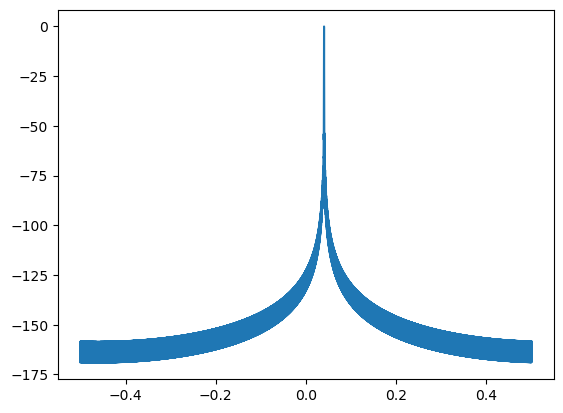

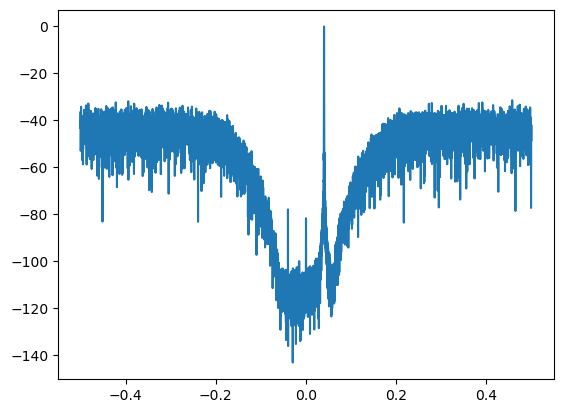

In [17]:
# Read data and metadata
x_meta, x = read_file_with_header('../data/sinData.txt')
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')

x_meta, x = read_file_with_header('../data/sinData.txt')
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')

N = len(x)

w = signal.barthann(len(x), False)
x_win = x * w
y_win = y * w

XdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_win))))
YdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(y_win))))

freqs = (np.arange(N) / N - 0.5)

plt.plot(freqs, XdB - np.max(XdB))
plt.show()

plt.plot(freqs, YdB - np.max(YdB))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1048576,) and (8192,)

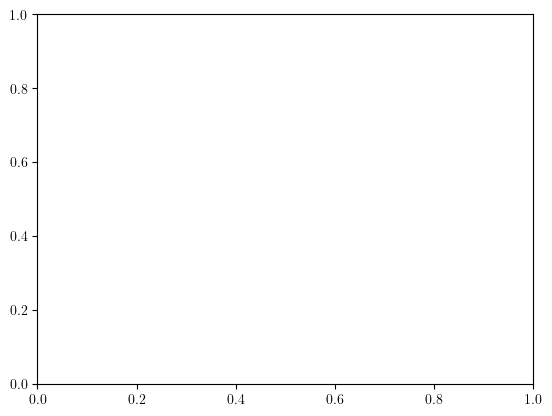

In [32]:
plt.plot(freqs, np.angle(np.fft.fftshift(np.fft.fft(x))))

In [14]:
y_serial_meta, y_serial = read_file_with_header('../data/sinData_serialData_LUT3.txt')
testSignal = y_serial
NyqZones = 4

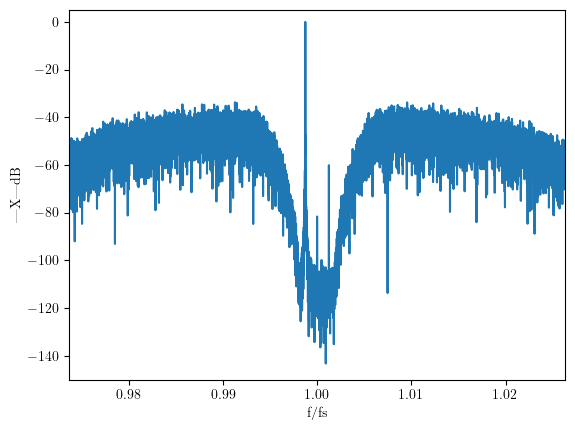

In [26]:
nrz = np.ones(NyqZones-3)

x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1+3) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + M - 1 = N*M as it should be!
x_upsampled[::NyqZones] = testSignal.real
x_upsampled[1::NyqZones] = testSignal.imag
x_upsampled[2::NyqZones] = -testSignal.real
x_upsampled[3::NyqZones] = -testSignal.imag

x_nrz = np.convolve(nrz, x_upsampled)

w = signal.barthann(len(x_nrz), False)
x_nrz_win = x_nrz * w

XnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_nrz_win))))
XnrzdB -= np.max(XnrzdB)

freqs = (np.arange(len(x_nrz_win)) / len(x_nrz_win) - 0.5) * NyqZones #* len(y_serial) / len(x)

plt.plot(freqs, XnrzdB)
# plt.ylim([-200, 0])
plt.xlim([1-0.5/(len(y_serial) / len(x)), 1+0.5/(len(y_serial) / len(x))])
plt.xlabel("f/fs")
plt.ylabel("|X|dB")
plt.ylim([-150, 5])
plt.show()

In [16]:
LUT1 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 7
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],  # Level 6
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],  # Level 5
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],  # Level 4
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 3
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # Level 2
    [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 1
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 0
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],  # Level -1
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],  # Level -2
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -3
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -4
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -5
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Level -8
    ]

LUT2 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],  # Level 7
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],  # Level 6
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 5
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 4
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 3
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 2
    [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 1
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # Level 0
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -1
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -2
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -3
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -4
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -5
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -6
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # Level -8
]

LUT3 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],  # Level 7
    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 6
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 5
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],  # Level 4
    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],  # Level 3
    [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1],  # Level 2
    [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1],  # Level 1
    [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0],  # Level 0
    [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],  # Level -1
    [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],  # Level -2
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],  # Level -3
    [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],  # Level -4
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -5
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -6
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # Level -8    
]

LUT4 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 7.5
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],  # Level 6.5
    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 5.5
    [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],  # Level 4.5
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],  # Level 3.5
    [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],  # Level 2.5
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # Level 1.5
    [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1],  # Level 0.5
    [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0],  # Level -0.5
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],  # Level -1.5
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],  # Level -2.5
    [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],  # Level -3.5
    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],  # Level -4.5
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -5.5
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Level -6.5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Level -7.5
]

LUT5 = [
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],  # Level 7.5
    [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],  # Level 6.5
    [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],  # Level 5.5
    [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1],  # Level 4.5
    [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],  # Level 3.5
    [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],  # Level 2.5
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 1.5
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],  # Level 0.5
    [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],  # Level -0.5
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # Level -1.5
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],  # Level -2.5
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],  # Level -3.5
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],  # Level -4.5
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],  # Level -5.5
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Level -6.5
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]   # Level -7.5    
]

def transLUT(LUT):
    return [[-1 if value==0 else value for value in row] for row in LUT]

LUTs = [LUT1, LUT2, LUT3, LUT4, LUT5]

for LUT in LUTs:
    for row in transLUT(LUT):
        print(sum(row))
    print('\n')

16
14
12
10
8
6
4
2
0
-2
-4
-6
-8
-10
-12
-14
-16


32
28
24
20
16
12
8
4
0
-4
-8
-12
-16
-20
-24
-28
-32


32
28
24
20
16
12
8
4
0
-4
-8
-12
-16
-20
-24
-28
-32


15
13
11
9
7
5
3
1
-1
-3
-5
-7
-9
-11
-13
-15


15
13
11
9
7
5
3
1
-1
-3
-5
-7
-9
-11
-13
-15




In [13]:
l5 = transLUT(LUT5)

print(l5[1], sum(l5[1]))

[1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1] 13


In [50]:
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')
print(np.mean(y))

(-0.001708984375+0.0030517578125j)


In [20]:
print(y[:10])

[ 4.+0.j  4.+1.j  3.+2.j  4.+2.j  1.+5.j  1.+3.j  2.+3.j -2.+5.j -2.+3.j
 -2.+4.j]


In [54]:
from fxpmath import Fxp

N = 2**16
n = np.arange(N)
F = 0.32

x = 8.0 * np.sin(2 * np.pi * F * n)
print(f'np.mean(x) = {np.mean(x)}')

xfxp = [Fxp(val, signed=True, n_word=4, n_frac=0, overflow='saturate', rounding='floor') for val in x]
xfxp = np.array(xfxp)

np.mean(x) = 8.481247960324335e-05


In [56]:
ticks = np.linspace(-8,8,len(x))

# plt.plot(ticks, xfxp+0.5)
# plt.grid()
# ticks = range(-8, 9)  # Create a range from -8 to 8 (inclusive)
# plt.xticks(ticks)  # Set x-axis ticks
# plt.yticks(ticks)  # Set y-axis ticks
# plt.show()

xfxp_ = [value+1 if value%2==0 else value for value in xfxp]

print(np.mean(xfxp+0.5), np.mean(xfxp_))

0.01348876953125 0.02685546875


In [53]:
print(np.max(x), np.min(x))

6.986187099006287 -6.986187099000572
